In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# ============================================================
# Finite difference schemes for spatial derivative df/dx
# ============================================================
def finite_diff_up1(wk, i, dx, c):
    """
    1st-order upwind finite difference for df/dx.
    The stencil direction depends on the sign of advection speed c.
    """
    return (wk[i] - wk[i-1]) / dx if c > 0 else (wk[i+1] - wk[i]) / dx

def finite_diff_cf2(wk, i, dx, c):
    """
    2nd-order central finite difference for df/dx.
    """
    return (wk[i+1] - wk[i-1]) / (2 * dx)

def finite_diff_up3(wk, i, dx, c):
    """
    3rd-order upwind finite difference for df/dx.
    """
    return (+2*wk[i+1] + 3*wk[i] - 6*wk[i-1] + wk[i-2]) / (6*dx) if c > 0 else \
           (-2*wk[i-1] - 3*wk[i] + 6*wk[i+1] - wk[i+2]) / (6*dx)

def finite_diff_cf4(wk, i, dx, c):
    """
    4th-order central finite difference for df/dx.
    """
    return (-wk[i+2] + 8*wk[i+1] - 8*wk[i-1] + wk[i-2]) / (12 * dx)


def finite_diff_up5(wk, i, dx, c):
    """
    5th-order upwind finite difference for df/dx.
    """
    return (-3*wk[i+2] + 30*wk[i+1] + 20*wk[i] - 60*wk[i-1] + 15*wk[i-2] - 2*wk[i-3]) / (60*dx) if c > 0 else \
           (+3*wk[i-2] - 30*wk[i-1] - 20*wk[i] + 60*wk[i+1] - 15*wk[i+2] + 2*wk[i+3]) / (60*dx)


# ============================================================
# Time integration schemes for df/dt = RHS(f)
# ============================================================
def time_integrate_euler(f, time_diff, dt):
    """
    Explicit Euler method (1st-order accurate in time).
    """
    k1 = time_diff(f)
    return f + dt * k1

def time_integrate_rk2(f, time_diff, dt):
    """
    2nd-order Runge–Kutta method (midpoint scheme).
    """
    k1 = time_diff(f)
    k2 = time_diff(f + 0.5 * dt * k1)
    return f + dt * k2

def time_integrate_rk4(f, time_diff, dt):
    """
    Classical 4th-order Runge–Kutta method.
    """
    k1 = time_diff(f)
    k2 = time_diff(f + 0.5 * dt * k1)
    k3 = time_diff(f + 0.5 * dt * k2)
    k4 = time_diff(f + dt * k3)
    return f + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)


# ============================================================
# Main solver for the 1D linear advection equation
#     df/dt + c df/dx = 0
# ============================================================
def linear_advection_simulation(flag_init="gau", flag_time="rk4", flag_diff="up3"):
    """
    Solve the 1D linear advection equation with periodic boundary conditions.

    Equation
    --------
    df/dt + c df/dx = 0

    Parameters
    ----------
    flag_init : str
        Initial condition ('sin', 'gau', or 'box')
    flag_time : str
        Time integration scheme ('euler', 'rk2', or 'rk4')
    flag_diff : str
        Spatial finite difference scheme
        ('up1', 'cf2', 'up3', 'cf4', or 'up5')

    Returns
    -------
    t_all : ndarray
        Array of time points
    f_all : ndarray
        Solution f(x,t) at stored time points
    x : ndarray
        Spatial grid
    """

    # --- Physical and numerical parameters ---
    c = np.pi          # constant advection speed
    nt = 1000          # number of time steps
    nskip = 1          # output interval
    dt = 0.01          # time step size
    nx = 64            # number of spatial grid points
    lx = 2 * np.pi     # domain length
    dx = lx / nx       # grid spacing

    # Uniform grid (periodic)
    x = np.linspace(0, lx, nx, endpoint=False)

    # ------------------------------------------------------------
    # Initial condition
    # ------------------------------------------------------------
    def init():
        if flag_init == "sin":
            # Smooth sinusoidal wave
            return np.sin(x)
        elif flag_init == "gau":
            # Localized Gaussian pulse
            return np.exp(-((x - 0.5 * lx)**2) / (0.1 * lx)**2)
        elif flag_init == "box":
            # Heaviside step function
            f = np.zeros_like(x)
            f[:nx//2] = 1.0
            return f
        else:
            raise ValueError("flag_init should be 'sin', 'gau', or 'box'")

    # ------------------------------------------------------------
    # Select spatial finite difference scheme
    # ------------------------------------------------------------
    if flag_diff == "up1":
        def finite_diff(wk, i): return finite_diff_up1(wk, i, dx, c)
    elif flag_diff == "cf2":
        def finite_diff(wk, i): return finite_diff_cf2(wk, i, dx, c)
    elif flag_diff == "up3":
        def finite_diff(wk, i): return finite_diff_up3(wk, i, dx, c)
    elif flag_diff == "cf4":
        def finite_diff(wk, i): return finite_diff_cf4(wk, i, dx, c)
    elif flag_diff == "up5":
        def finite_diff(wk, i): return finite_diff_up5(wk, i, dx, c)
    else:
        raise ValueError("flag_diff should be 'up1', 'cf2', 'up3', 'cf4', or 'up5'.")

    # ------------------------------------------------------------
    # Right-hand side: -c df/dx
    # ------------------------------------------------------------
    def time_diff(f):
        """
        Compute the right-hand side of the advection equation:
            df/dt = -c * df/dx
        """
        # Periodic extension for finite difference stencil
        wk = np.concatenate([f[-3:], f, f[:3]])
        dfdx = np.zeros_like(f)

        # Compute spatial derivative point by point
        for ix in range(nx):
            i = ix + 3
            dfdx[ix] = finite_diff(wk, i)

        return -c * dfdx

    # ------------------------------------------------------------
    # Select time integration scheme
    # ------------------------------------------------------------
    if flag_time == "euler":
        def time_step(f): return time_integrate_euler(f, time_diff, dt)
    elif flag_time == "rk2":
        def time_step(f): return time_integrate_rk2(f, time_diff, dt)
    elif flag_time == "rk4":
        def time_step(f): return time_integrate_rk4(f, time_diff, dt)
    else:
        raise ValueError("flag_time should be 'euler', 'rk2', or 'rk4'")

    # ------------------------------------------------------------
    # Time stepping loop
    # ------------------------------------------------------------
    t_all, f_all = [], []
    t = 0.0
    f = init()

    for it in range(nt):
        if it % nskip == 0:
            # Store solution snapshot
            t_all.append(t)
            f_all.append(f.copy())

        # Advance one time step
        f = time_step(f)
        t += dt

    return np.array(t_all), np.array(f_all), x


In [9]:
# --- Run simulation ---
flag_init = "gau"
flag_time = "rk4"
flag_diff = "up3"
t_all, f_all, x = linear_advection_simulation(flag_init=flag_init, flag_time=flag_time, flag_diff=flag_diff)

title_tag = f"{flag_time.upper()} + {flag_diff.upper()}"

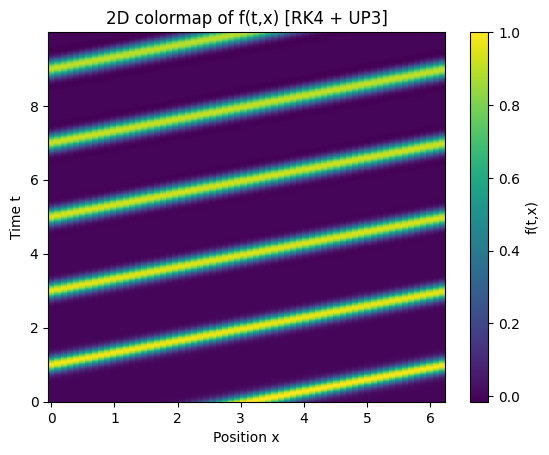

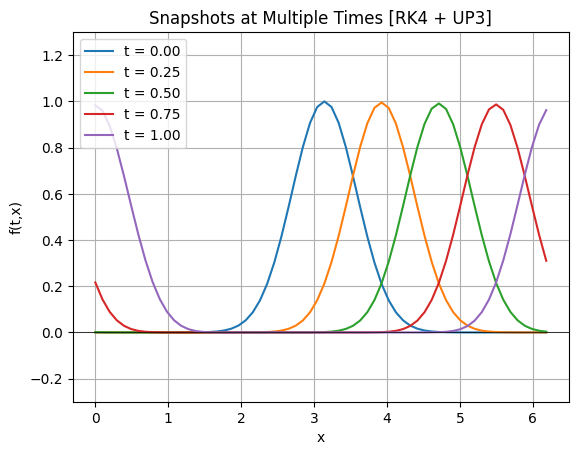

In [10]:
# --- 2D colormap ---
fig, ax = plt.subplots()
cmap = ax.pcolormesh(x, t_all, f_all, shading='auto')
fig.colorbar(cmap, ax=ax, label="f(t,x)")
ax.set_xlabel("Position x")
ax.set_ylabel("Time t")
ax.set_title(f"2D colormap of f(t,x) [{title_tag}]")
plt.show()

# --- Multiple snapshots ---
fig, ax = plt.subplots()
for i in [0, 25, 50, 75, 100]:
    if i < len(t_all):
        ax.plot(x, f_all[i], label=f"t = {t_all[i]:.2f}")
ax.set_xlabel("x")
ax.set_ylabel("f(t,x)")
ax.set_ylim(-0.3, 1.3)
ax.axhline(0, lw=0.5, c="k")
ax.legend()
ax.set_title(f"Snapshots at Multiple Times [{title_tag}]")
ax.grid(True)
plt.show()

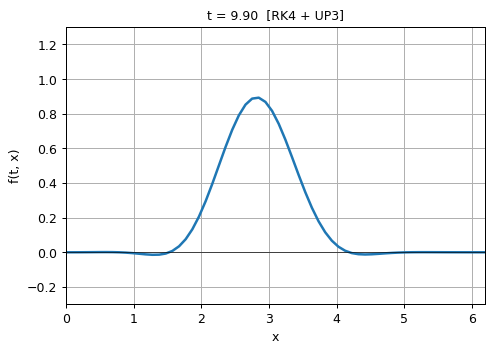

In [11]:
# --- Animation ---
fig, ax = plt.subplots(figsize=(6, 4), dpi=90)
line, = ax.plot([], [], lw=2)
title = ax.text(0.5, 1.02, "", transform=ax.transAxes, ha="center", va="bottom")
ax.set_xlim(x[0], x[-1])
ax.set_ylim(-0.3, 1.3)
ax.axhline(0.0, lw=0.5, c="k")
ax.set_xlabel("x")
ax.set_ylabel("f(t, x)")
ax.grid(True)

def init():
    line.set_data([], [])
    title.set_text("")
    return line, title
def update(i):
    line.set_data(x, f_all[i])
    title.set_text(f"t = {t_all[i]:.2f}  [{title_tag}]")
    return line, title

ani = FuncAnimation(fig, update,
                    frames=list(range(0, len(t_all), 10)),
                    interval=50, blit=True, init_func=init)
HTML(ani.to_jshtml())